## ENGG* 6600 Security of Cyber Grids
### Prof. Hadis Karimipour

### Project Title - Identifying suspicious URLs using Supervised Learning and Lexical Analysis

#### Coded by Ruthvik Raja M.V (1162634) and Debanjan Mitra (1126062)

## Binary Classifcation using PCA and Correlation Technique

# Imports

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

In [2]:
# Loading Malware, Spam, Phishing and Defacement Datasets
# Each Dataset also consists of Benign URL's

malware=pd.read_csv("Dataset/Malware.csv")
spam=pd.read_csv("Dataset/Spam.csv")
phishing=pd.read_csv("Dataset/Phishing.csv")
defacement=pd.read_csv("Dataset/Defacement.csv")

In [3]:
# Data Cleaning: Strip whitespaces from the column names and drop NA values

malware = malware.rename(str.strip, axis='columns')
spam=spam.rename(str.strip, axis="columns")
phishing=phishing.rename(str.strip, axis="columns")
defacement=defacement.rename(str.strip, axis="columns")

In [4]:
# Malware and Benign
# In Malware Dataset nearly 40% of values are NULL values in the NumberRate_Extension column

malware1=malware.drop(["NumberRate_Extension"], axis=1)
malware1=malware1.dropna()
malware1=shuffle(malware1)
malware1=malware1.reset_index(drop=True)

In [5]:
# If URL_Type_obf_Type == "malware" [class label 0], else [class label 1]

# Function to label the classes in a DataFrame
def class_labels_malware(class_name):
    if(class_name=="malware"):
        return 0
    else:
        return 1
   
# Function for Data Scaling
def dataset_scaling(dataset):
        
  # Scaling dataset
  scaler = MinMaxScaler(feature_range=(0, 1)) # Scaling object for features 
  
  df_X = dataset.loc[:, dataset.columns!="URL_Type_obf_Type"]
  df_Y = dataset[["URL_Type_obf_Type"]]
  
  df_X = scaler.fit_transform(df_X)
  dataset1=np.concatenate((df_X, df_Y), axis=1)
  
  return dataset1, scaler    
    
# Function for appending the column indices with correlation value closer to 0
def columns_lowcorr(corr, columns):
    index_lowcorr=[]
    for i in range(0, corr.shape[1]):
        if((-0.1 < corr.iloc[-1,i] < 0.1) or (pd.isnull(corr.iloc[-1,i]))):
            print(columns[-1],"and",columns[i],"with Correlation",round(corr.iloc[-1][i],2))
            index_lowcorr.append(i)
    return index_lowcorr        

# Function for appending the features with high correlation
def columns_highcorr(corr, columns):
    index_highcorr=[]
    for i in range(0, corr.shape[0]-1):
        for j in range(i, corr.shape[1]-1):
            if(0.8<=corr.iloc[i][j]<1):
                print(columns[i],"and",columns[j],"with Correlation",round(corr.iloc[i][j],2))
                if(i not in index_highcorr):
                    index_highcorr.append(i);
                 
    return index_highcorr

# Function to determine the final Index column indices with low and high correlation values
def final_index(index_lowcorr, index_highcorr):
    index=[]
    for i in index_lowcorr:
        if i not in index:
            index.append(i)
    for j in index_highcorr:
        if j not in index:
            index.append(j) 
    index.sort()
    return index


In [6]:
malware1["URL_Type_obf_Type"]=malware1["URL_Type_obf_Type"].apply(lambda x:class_labels_malware(x))
malware_columns=malware1.columns

corr=malware1.corr()

# Removing all the columns with correlation almost equal to 0 ->
# Which shows no impact on the O/P variable and the features with High Correlation      

print("<-----Features with Low Correlation Value----->") 
index_malware_lowcorr=columns_lowcorr(corr, malware_columns)
print("<---------------------------------------------->")
print("<-----Features with High Correlation Value----->")
index_malware_highcorr=columns_highcorr(corr, malware_columns)
index_malware=final_index(index_malware_lowcorr, index_malware_highcorr)

malware3=malware1.drop(columns=malware_columns[[index_malware]])
            
malware2, scaler=dataset_scaling(malware3) # Scaling the Dataset

malware2=pd.DataFrame(malware2,columns=malware3.columns)
# After, performing scaling the output will be of type array so storing it as a DataFrame

<-----Features with Low Correlation Value----->
URL_Type_obf_Type and Querylength with Correlation -0.09
URL_Type_obf_Type and avgdomaintokenlen with Correlation -0.0
URL_Type_obf_Type and avgpathtokenlen with Correlation 0.07
URL_Type_obf_Type and ldl_filename with Correlation -0.04
URL_Type_obf_Type and dld_domain with Correlation nan
URL_Type_obf_Type and dld_filename with Correlation -0.01
URL_Type_obf_Type and urlLen with Correlation 0.06
URL_Type_obf_Type and fileNameLen with Correlation 0.02
URL_Type_obf_Type and this.fileExtLen with Correlation 0.07
URL_Type_obf_Type and argDomanRatio with Correlation -0.08
URL_Type_obf_Type and executable with Correlation -0.07
URL_Type_obf_Type and isPortEighty with Correlation -0.03
URL_Type_obf_Type and ISIpAddressInDomainName with Correlation nan
URL_Type_obf_Type and LongestVariableValue with Correlation -0.07
URL_Type_obf_Type and Directory_DigitCount with Correlation 0.02
URL_Type_obf_Type and File_name_DigitCount with Correlation -0.0


C:\Users\deban\anaconda3\lib\site-packages\pandas\core\indexes\base.py:4111: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [7]:
# Principal Component Analysis

# Separating the input and output features
X=malware2.loc[:, malware2.columns!="URL_Type_obf_Type"]
y=malware2["URL_Type_obf_Type"]

# Let's say, components = 10
pca = PCA(n_components = 10)
pca.fit(X)
X_pca = pca.transform(X)

In [8]:
# Splitting the samples
train_x, test_x, train_y, test_y=train_test_split(X_pca, y, random_state=0, test_size=0.25)

In [9]:
# Machine Learning Models
start = time.time()
svm=SVC()
svm.fit(train_x, train_y)
y_score_malware = svm.decision_function(test_x)
predicted_test=svm.predict(test_x)
end = time.time()
print((end-start)) # Prints Time taken by the Model to train and execute the samples in seconds
 # Using PCA it took only 0.93 seconds

0.9874966144561768


In [10]:
# Predicting the Output
predicted_train=svm.predict(train_x)

In [11]:
# Performance Metrics
accuracy_score(test_y, predicted_test) * 100 # 89.77% for testing

89.77820636451301

In [12]:
accuracy_score(train_y, predicted_train) * 100 # 90.31% for training

90.31186368020576

In [13]:
# confusion matrix
matrix = confusion_matrix(train_y,predicted_train,labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(train_y,predicted_train,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(train_y,predicted_train,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[4812  147]
 [ 757 3615]]
Outcome values : 
 4812 147 757 3615
Classification report : 
               precision    recall  f1-score   support

           1       0.86      0.97      0.91      4959
           0       0.96      0.83      0.89      4372

    accuracy                           0.90      9331
   macro avg       0.91      0.90      0.90      9331
weighted avg       0.91      0.90      0.90      9331



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.97')

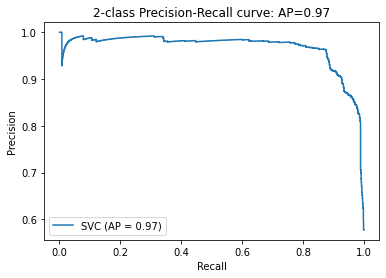

In [14]:
average_precision = average_precision_score(test_y, y_score_malware)
disp = plot_precision_recall_curve(svm, test_x, test_y)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [15]:
# Spam and Benign 
# In Spam Dataset nearly 34% of values are NULL values in the NumberRate_Extension column

spam1=spam.drop(["NumberRate_Extension"], axis=1)
spam1=spam1.dropna()
spam1=shuffle(spam1)
spam1=spam1.reset_index(drop=True)
spam1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12420 entries, 0 to 12419
Data columns (total 79 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      12420 non-null  int64  
 1   domain_token_count               12420 non-null  int64  
 2   path_token_count                 12420 non-null  int64  
 3   avgdomaintokenlen                12420 non-null  float64
 4   longdomaintokenlen               12420 non-null  int64  
 5   avgpathtokenlen                  12420 non-null  float64
 6   tld                              12420 non-null  int64  
 7   charcompvowels                   12420 non-null  int64  
 8   charcompace                      12420 non-null  int64  
 9   ldl_url                          12420 non-null  int64  
 10  ldl_domain                       12420 non-null  int64  
 11  ldl_path                         12420 non-null  int64  
 12  ldl_filename      

In [16]:
# If URL_Type_obf_Type == "spam" [class label 0], else [class label 1]

# Function to label the classes in a DataFrame
def class_labels_spam(class_name):
    if(class_name=="spam"):
        return 0
    else:
        return 1
    
spam1["URL_Type_obf_Type"]=spam1["URL_Type_obf_Type"].apply(lambda x:class_labels_spam(x))
spam_columns=spam1.columns

corr=spam1.corr()

In [17]:
# Removing all the columns with correlation almost equal to 0 ->
# Which shows no impact on the O/P variable and the features with High Correlation      

print("<-----Features with Low Correlation Value----->") 
index_spam_lowcorr=columns_lowcorr(corr, spam_columns)
print("<---------------------------------------------->")
print("<-----Features with High Correlation Value----->")
index_spam_highcorr=columns_highcorr(corr, spam_columns)
index_spam=final_index(index_spam_lowcorr, index_spam_highcorr)

spam3=spam1.drop(columns=spam_columns[[index_spam]])
            
spam2, scaler=dataset_scaling(spam3) # Scaling the Dataset
spam2=pd.DataFrame(spam2,columns=spam3.columns)

<-----Features with Low Correlation Value----->
URL_Type_obf_Type and path_token_count with Correlation 0.1
URL_Type_obf_Type and avgpathtokenlen with Correlation 0.09
URL_Type_obf_Type and dld_domain with Correlation nan
URL_Type_obf_Type and dld_filename with Correlation 0.1
URL_Type_obf_Type and this.fileExtLen with Correlation 0.03
URL_Type_obf_Type and pathurlRatio with Correlation 0.04
URL_Type_obf_Type and executable with Correlation nan
URL_Type_obf_Type and isPortEighty with Correlation nan
URL_Type_obf_Type and ISIpAddressInDomainName with Correlation nan
URL_Type_obf_Type and host_DigitCount with Correlation -0.01
URL_Type_obf_Type and Directory_DigitCount with Correlation 0.1
URL_Type_obf_Type and Directory_LetterCount with Correlation -0.09
URL_Type_obf_Type and Path_LongestWordLength with Correlation 0.02
URL_Type_obf_Type and sub-Directory_LongestWordLength with Correlation -0.02
URL_Type_obf_Type and URL_sensitiveWord with Correlation -0.08
URL_Type_obf_Type and spcharU

C:\Users\deban\anaconda3\lib\site-packages\pandas\core\indexes\base.py:4111: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [18]:
# Principal Component Analysis

# Separating the input and output features
X=spam2.loc[:, spam2.columns!="URL_Type_obf_Type"]
y=spam2["URL_Type_obf_Type"]

# Let's say, components = 6
pca = PCA(n_components = 6)
pca.fit(X)
X_pca = pca.transform(X)

In [19]:
# Splitting the samples
train_x, test_x, train_y, test_y=train_test_split(X_pca, y, random_state=0, test_size=0.25)

In [20]:
# Machine Learning Models
start = time.time()
svm=SVC()
svm.fit(train_x, train_y)
predicted_test=svm.predict(test_x)
y_score_spam = svm.decision_function(test_x)
end = time.time()
print((end-start)) # Prints Time taken by the Model to train and execute the samples in seconds

0.1331183910369873


In [21]:
# Predicting the Output
predicted_train=svm.predict(train_x)

In [22]:
# Performance Metrics
accuracy_score(test_y, predicted_test) * 100 # 98.77% for testing

98.77616747181965

In [23]:
accuracy_score(train_y, predicted_train) * 100 # 98.65% for training

98.6580783682233

In [24]:
# confusion matrix
matrix = confusion_matrix(train_y,predicted_train,labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(train_y,predicted_train,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(train_y,predicted_train,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[4841   99]
 [  26 4349]]
Outcome values : 
 4841 99 26 4349
Classification report : 
               precision    recall  f1-score   support

           1       0.99      0.98      0.99      4940
           0       0.98      0.99      0.99      4375

    accuracy                           0.99      9315
   macro avg       0.99      0.99      0.99      9315
weighted avg       0.99      0.99      0.99      9315



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=1.00')

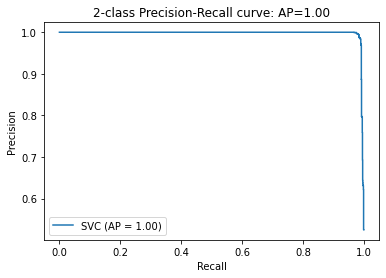

In [25]:
average_precision = average_precision_score(test_y, y_score_spam)
disp = plot_precision_recall_curve(svm, test_x, test_y)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

### Phishing and Benign

In [26]:
# In Phishing Dataset nearly 48% of values are NULL values in the NumberRate_Extension column

phishing1=phishing.drop(["NumberRate_Extension"], axis=1)
phishing1=phishing1.dropna()
phishing1=shuffle(phishing1)
phishing1=phishing1.reset_index(drop=True)
phishing1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13084 entries, 0 to 13083
Data columns (total 79 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      13084 non-null  int64  
 1   domain_token_count               13084 non-null  int64  
 2   path_token_count                 13084 non-null  int64  
 3   avgdomaintokenlen                13084 non-null  float64
 4   longdomaintokenlen               13084 non-null  int64  
 5   avgpathtokenlen                  13084 non-null  float64
 6   tld                              13084 non-null  int64  
 7   charcompvowels                   13084 non-null  int64  
 8   charcompace                      13084 non-null  int64  
 9   ldl_url                          13084 non-null  int64  
 10  ldl_domain                       13084 non-null  int64  
 11  ldl_path                         13084 non-null  int64  
 12  ldl_filename      

In [27]:
# If URL_Type_obf_Type == "phishing" [class label 0], else [class label 1]

# Function to label the classes in a DataFrame
def class_labels_phishing(class_name):
    if(class_name=="phishing"):
        return 0
    else:
        return 1
    
phishing1["URL_Type_obf_Type"]=phishing1["URL_Type_obf_Type"].apply(lambda x:class_labels_phishing(x))
phishing_columns=phishing1.columns

corr=phishing1.corr()

In [28]:
# Removing all the columns with correlation almost equal to 0 ->
 # Which shows no impact on the O/P variable and the features with High Correlation      

print("<-----Features with Low Correlation Value----->") 
index_phishing_lowcorr=columns_lowcorr(corr, phishing_columns)
print("<---------------------------------------------->")
print("<-----Features with High Correlation Value----->")
index_phishing_highcorr=columns_highcorr(corr, phishing_columns)
index_phishing=final_index(index_phishing_lowcorr, index_phishing_highcorr)

phishing3=phishing1.drop(columns=phishing_columns[[index_phishing]])
            
phishing2, scaler=dataset_scaling(phishing3) # Scaling the Dataset
phishing2=pd.DataFrame(phishing2,columns=phishing3.columns)

<-----Features with Low Correlation Value----->
URL_Type_obf_Type and Querylength with Correlation 0.02
URL_Type_obf_Type and avgpathtokenlen with Correlation -0.05
URL_Type_obf_Type and ldl_domain with Correlation -0.07
URL_Type_obf_Type and ldl_filename with Correlation -0.0
URL_Type_obf_Type and dld_domain with Correlation -0.04
URL_Type_obf_Type and dld_filename with Correlation 0.04
URL_Type_obf_Type and urlLen with Correlation 0.1
URL_Type_obf_Type and ArgLen with Correlation -0.03
URL_Type_obf_Type and ArgUrlRatio with Correlation -0.01
URL_Type_obf_Type and argDomanRatio with Correlation 0.03
URL_Type_obf_Type and argPathRatio with Correlation -0.06
URL_Type_obf_Type and executable with Correlation -0.01
URL_Type_obf_Type and isPortEighty with Correlation nan
URL_Type_obf_Type and ISIpAddressInDomainName with Correlation nan
URL_Type_obf_Type and LongestVariableValue with Correlation 0.01
URL_Type_obf_Type and URL_DigitCount with Correlation -0.06
URL_Type_obf_Type and host_Dig

C:\Users\deban\anaconda3\lib\site-packages\pandas\core\indexes\base.py:4111: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [29]:
# Principal Component Analysis
# Separating the input and output features
X=phishing2.loc[:, phishing2.columns!="URL_Type_obf_Type"]
y=phishing2["URL_Type_obf_Type"]
 
# Let's say, components = 10
pca = PCA(n_components = 10)
pca.fit(X)
X_pca = pca.transform(X)

In [30]:
# Splitting the samples
train_x, test_x, train_y, test_y=train_test_split(X_pca, y, random_state=0, test_size=0.25)

In [31]:
# Machine Learning Models
start = time.time()
svm=SVC()
svm.fit(train_x, train_y)
predicted_test=svm.predict(test_x)
y_score_phising = svm.decision_function(test_x)
end = time.time()
print((end-start)) # Prints Time taken by the Model to train and execute the samples in seconds

0.51979660987854


In [32]:
# Predicting the Output
predicted_train=svm.predict(train_x)

In [33]:
# Performance Metrics
accuracy_score(test_y, predicted_test) * 100 # 96.39% for testing

96.39254050749007

In [34]:
accuracy_score(train_y, predicted_train) * 100 # 95.77% for training

95.77091613166208

In [35]:
# confusion matrix
matrix = confusion_matrix(train_y,predicted_train,labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(train_y,predicted_train,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(train_y,predicted_train,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[4798  134]
 [ 281 4600]]
Outcome values : 
 4798 134 281 4600
Classification report : 
               precision    recall  f1-score   support

           1       0.94      0.97      0.96      4932
           0       0.97      0.94      0.96      4881

    accuracy                           0.96      9813
   macro avg       0.96      0.96      0.96      9813
weighted avg       0.96      0.96      0.96      9813



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.99')

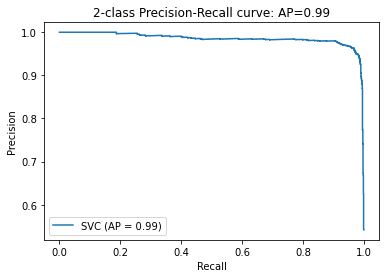

In [36]:
average_precision = average_precision_score(test_y, y_score_phising)
disp = plot_precision_recall_curve(svm, test_x, test_y)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

### Defacement and Benign

In [37]:
# In Defacement Dataset nearly 39% of values are NULL values in the Entropy_DirectoryName
 # and 32% of values are NULL values in the NumberRate_Extension column

# If we are using the dropna() on the Defacement Dataset, the number of rows falls from 
 # 15711 to 5186 rows but if we drop the above two columns and apply dropna() then the number
  # of rows reduces from 15711 to 15477 so, better to drop the two columns

defacement1=defacement.drop(["NumberRate_Extension", "Entropy_DirectoryName"], axis=1)
defacement1=defacement1.dropna()
defacement1=shuffle(defacement1) 
defacement1=defacement1.reset_index(drop=True)
defacement1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15477 entries, 0 to 15476
Data columns (total 78 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      15477 non-null  int64  
 1   domain_token_count               15477 non-null  int64  
 2   path_token_count                 15477 non-null  int64  
 3   avgdomaintokenlen                15477 non-null  float64
 4   longdomaintokenlen               15477 non-null  int64  
 5   avgpathtokenlen                  15477 non-null  float64
 6   tld                              15477 non-null  int64  
 7   charcompvowels                   15477 non-null  int64  
 8   charcompace                      15477 non-null  int64  
 9   ldl_url                          15477 non-null  int64  
 10  ldl_domain                       15477 non-null  int64  
 11  ldl_path                         15477 non-null  int64  
 12  ldl_filename      

In [38]:
# If URL_Type_obf_Type == "Defacement" [class label 0], else [class label 1]

# Function to label the classes in a DataFrame
def class_labels_defacement(class_name):
    if(class_name=="Defacement"):
        return 0
    else:
        return 1
    
defacement1["URL_Type_obf_Type"]=defacement1["URL_Type_obf_Type"].apply(lambda x:class_labels_defacement(x))
defacement_columns=defacement1.columns

corr=defacement1.corr()

In [39]:
# Removing all the columns with correlation almost equal to 0 ->
 # Which shows no impact on the O/P variable and the features with High Correlation      

print("<-----Features with Low Correlation Value----->") 
index_defacement_lowcorr=columns_lowcorr(corr, defacement_columns)
print("<---------------------------------------------->")
print("<-----Features with High Correlation Value----->") 
index_defacement_highcorr=columns_highcorr(corr, defacement_columns)
index_defacement=final_index(index_defacement_lowcorr, index_defacement_highcorr)

defacement3=defacement1.drop(columns=defacement_columns[[index_defacement]])
            
defacement2, scaler=dataset_scaling(defacement3) # Scaling the Dataset
defacement2=pd.DataFrame(defacement2,columns=defacement3.columns)

<-----Features with Low Correlation Value----->
URL_Type_obf_Type and charcompvowels with Correlation -0.02
URL_Type_obf_Type and charcompace with Correlation 0.03
URL_Type_obf_Type and ldl_url with Correlation -0.01
URL_Type_obf_Type and ldl_path with Correlation -0.02
URL_Type_obf_Type and dld_url with Correlation 0.05
URL_Type_obf_Type and dld_domain with Correlation -0.01
URL_Type_obf_Type and dld_path with Correlation 0.05
URL_Type_obf_Type and dld_filename with Correlation 0.1
URL_Type_obf_Type and dld_getArg with Correlation -0.09
URL_Type_obf_Type and pathLength with Correlation -0.01
URL_Type_obf_Type and subDirLen with Correlation -0.01
URL_Type_obf_Type and this.fileExtLen with Correlation 0.09
URL_Type_obf_Type and executable with Correlation nan
URL_Type_obf_Type and isPortEighty with Correlation -0.01
URL_Type_obf_Type and ISIpAddressInDomainName with Correlation nan
URL_Type_obf_Type and host_DigitCount with Correlation -0.02
URL_Type_obf_Type and URL_sensitiveWord with 

C:\Users\deban\anaconda3\lib\site-packages\pandas\core\indexes\base.py:4111: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [40]:
# Principal Component Analysis

# Separating the input and output features
X=defacement2.loc[:, defacement2.columns!="URL_Type_obf_Type"]
y=defacement2["URL_Type_obf_Type"]

# Let's say, components = 10
pca = PCA(n_components = 10)
pca.fit(X)
X_pca = pca.transform(X)

In [41]:
# Splitting the samples
train_x, test_x, train_y, test_y=train_test_split(X_pca, y, random_state=0, test_size=0.25)

In [42]:
# Machine Learning Models
start = time.time()
svm=SVC()
svm.fit(train_x, train_y)
predicted_test=svm.predict(test_x)
y_score_defacement = svm.decision_function(test_x)
end = time.time()
print((end-start)) # Prints Time taken by the Model to train and execute the samples in seconds

0.6296553611755371


In [43]:
# Predicting the Output
predicted_train=svm.predict(train_x)

In [44]:
# Performance Metrics
accuracy_score(test_y, predicted_test) * 100 # 96.61% for testing

96.61498708010335

In [45]:
accuracy_score(train_y, predicted_train) * 100 # 96.63% for training

96.63134315499268

In [46]:
# confusion matrix
matrix = confusion_matrix(train_y,predicted_train,labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(train_y,predicted_train,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(train_y,predicted_train,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[5602  111]
 [ 280 5614]]
Outcome values : 
 5602 111 280 5614
Classification report : 
               precision    recall  f1-score   support

           1       0.95      0.98      0.97      5713
           0       0.98      0.95      0.97      5894

    accuracy                           0.97     11607
   macro avg       0.97      0.97      0.97     11607
weighted avg       0.97      0.97      0.97     11607



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.99')

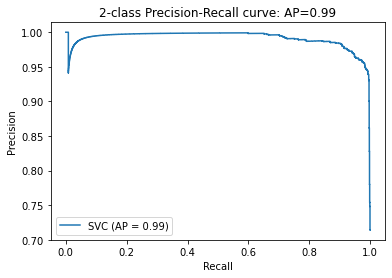

In [47]:
average_precision = average_precision_score(test_y, y_score_defacement)
disp = plot_precision_recall_curve(svm, test_x, test_y)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

### When we try to reduce the n_components value of PCA the accuracy score is also getting reduced. Hence, better value is chosen to capture the variability of the features.

### <---------------------- THE END -----------------------> ###